# **Black-box Models**

To avoid dependecy errors, it is recommended to create a new Python environment.

```bash
conda create -n black-box python=3.9
conda activate black-box
pip install dice-ml shap
pip install numpy pandas --upgrade
pip install matplotlib
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.inspection import permutation_importance

import shap
import dice_ml

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./filtered_df.csv')

In [2]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = LabelEncoder()

In [4]:
df["EnergyCertificate"]= encoder.fit_transform(df["EnergyCertificate"])
X = df.drop(["Price","Town","Garage","Parking"],axis=1)
X = pd.get_dummies(X, drop_first=True) 
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## **3.** Post-Modeling Explanations

The two black-box models we used for our case study were the [**Random Forest Regressor**](#rf) and a simple [**Neural Network**](#nn). Before running the models, we will define the **4 post-hoc XAI techniques**:
- One simplification-based technique: **Global Surrogates**.
- Two feature-based techniques: **Permutation Feature Importance** and **SHAP**.
- One example-based technique: **Counterfactuals**.

#### **3.1.** Global Surrogates

In [5]:
def global_surrogates(model, X_train, y_train):
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict using the model
    y_pre = model.predict(X)
    
    # Split the data for the surrogate model
    X_trai, X_tes, y_trai, y_tes = train_test_split(X, y_pre, test_size=0.3, random_state=42)
    
    # Instantiate the Decision Tree Regressor model
    dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)  # Adjust max_depth as needed

    # Fit the surrogate model to the training data
    dt_regressor.fit(X_trai, y_trai)

    # Make predictions
    y_pr = dt_regressor.predict(X_tes)

    # Evaluate the surrogate model (coefficient of determination)
    mse = mean_squared_error(y_tes, y_pr)
    r2 = r2_score(y_tes, y_pr)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
    # Plot the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True, fontsize=12)
    plt.title("Decision Tree Visualization", fontsize=16)
    plt.show()

### **3.2.1** Permutation Feature Importance

In [23]:
def permutation_feature(model,X_test, y_test):
    perm_importance = permutation_importance(
        model, X_test, y_test, n_repeats=30, random_state=42, scoring='r2'
    )
    sorted_idx = perm_importance.importances_mean.argsort()

    importances = pd.DataFrame(
        perm_importance.importances[sorted_idx].T,
        columns=X.columns[sorted_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()


### **3.2.2.** SHAP

In [10]:

def exec_shap(model,X_test):
    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)

    # Compute SHAP values for the test set
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)

### **3.3.** Counterfactuals

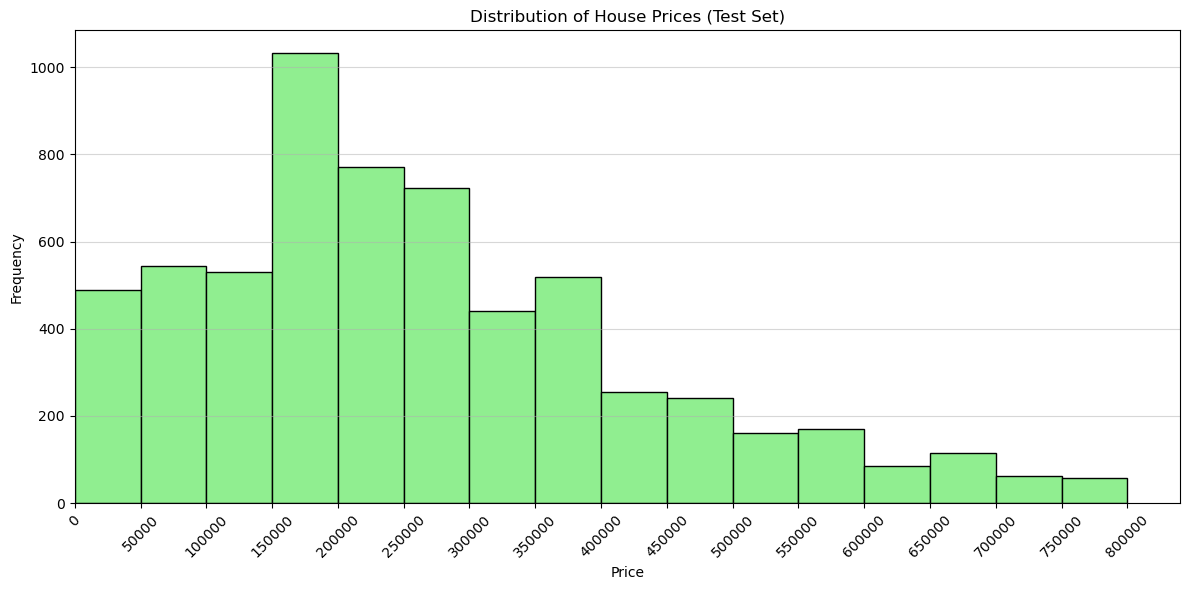

In [6]:
plt.figure(figsize=(12, 6))
bin_width = 50000 
min_price = 0
max_price = 800000

plt.hist(y_test, color='lightgreen', edgecolor='black', 
         bins=list(range(min_price, max_price + bin_width, bin_width)))
plt.xticks(range(min_price, max_price + bin_width, bin_width), rotation=45)
plt.title('Distribution of House Prices (Test Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.xlim(left=0)
plt.tight_layout()
plt.show()


- We will use 2 different examples: one from the most common price range **[150000,200000]**, and one from the least common **[700000,750000]**.

In [5]:
# list of X_test columns
X_test.columns

Index(['EnergyCertificate', 'ConstructionYear', 'TotalArea', 'Elevator',
       'ElectricCarsCharging', 'NumberOfBedrooms', 'NumberOfWC', 'LivingArea',
       'NumberOfBathrooms', 'District_Beja',
       ...
       'City_Vila do Conde', 'City_Vila do Porto', 'City_Vimioso',
       'City_Vinhais', 'City_Vizela', 'City_Águeda', 'City_Évora',
       'City_Ílhavo', 'City_Óbidos', 'Type_House'],
      dtype='object', length=291)

In [ ]:
def counterfactuals(model, X_test, y_test):
    X_test2 = X_test.copy()
    X_test2['Price'] = y_test

    bool_cols = X_test2.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X_test2[col] = X_test2[col].astype(int)
        
    m = dice_ml.Model(model=model, backend="sklearn", model_type='regressor')
    d = dice_ml.Data(dataframe=X_test2, continuous_features=['TotalArea', 'LivingArea'], outcome_name='Price')
    exp = dice_ml.Dice(d, m)
    
    exclude_features = [col for col in X_test2.columns if col.startswith('District_') or col.startswith('Region_')] + ['Price']
    features_to_vary = [col for col in X_test2.columns if col not in exclude_features]
    features_to_show = features_to_vary + ['Price']
    
    plt.figure(figsize=(12, 6))
    plt.hist(y_test, color='lightgreen', edgecolor='black', 
             bins=list(range(min_price, max_price + bin_width, bin_width)))
    plt.xticks(range(min_price, max_price + bin_width, bin_width), rotation=45)
    plt.title('Distribution of House Prices (Test Set)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.5)
    plt.xlim(left=0)
    
    # Example 1
    print("Example 1") 
    c_y1 = y_test[y_test.between(150000, 200000)]
    example1 = X_test2.loc[[c_y1.first_valid_index()]]
    query_instance = X_test2.drop(columns="Price").loc[[c_y1.first_valid_index()]]
    display(example1[features_to_show])
    dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_range=[0.0, 1000000000000.0], features_to_vary=features_to_vary,random_seed=42)
    df_cf1 = dice_exp.cf_examples_list[0].final_cfs_df
    display(df_cf1[features_to_show])
    
    # Plot original point and counterfactuals for Example 1
    plt.scatter([example1['Price'].values[0]] * 4, range(10, 14), color='red', label='Original Example 1')
    plt.scatter(df_cf1['Price'], range(10, 14), color='blue', label='Counterfactuals Example 1')
    
    print("Example 2") 
    # Example 2
    c_y2 = y_test[y_test.between(700000, 750000)]
    example2 = X_test2.loc[[c_y2.first_valid_index()]]
    query_instance = X_test2.drop(columns="Price").loc[[c_y2.first_valid_index()]]
    display(example2[features_to_show])
    dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_range=[0.0, 1000000000000.0], features_to_vary=features_to_vary,random_seed=42)
    df_cf2 = dice_exp.cf_examples_list[0].final_cfs_df
    display(df_cf2[features_to_show])
    
    # Plot original point and counterfactuals for Example 2
    plt.scatter([example2['Price'].values[0]] * 4, range(14, 18), color='orange', label='Original Example 2')
    plt.scatter(df_cf2['Price'], range(14, 18), color='purple', label='Counterfactuals Example 2')
    
    plt.legend()
    plt.tight_layout()
    plt.show()


<a id="rf"></a>
## **Black-box Model 1** : Random Forest Regressor
(Go back to [**Section 3**](#3-post-modeling-explanations))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.7173719027715804
Mean Squared Error: 8160176464.07
R^2 Score: 0.71


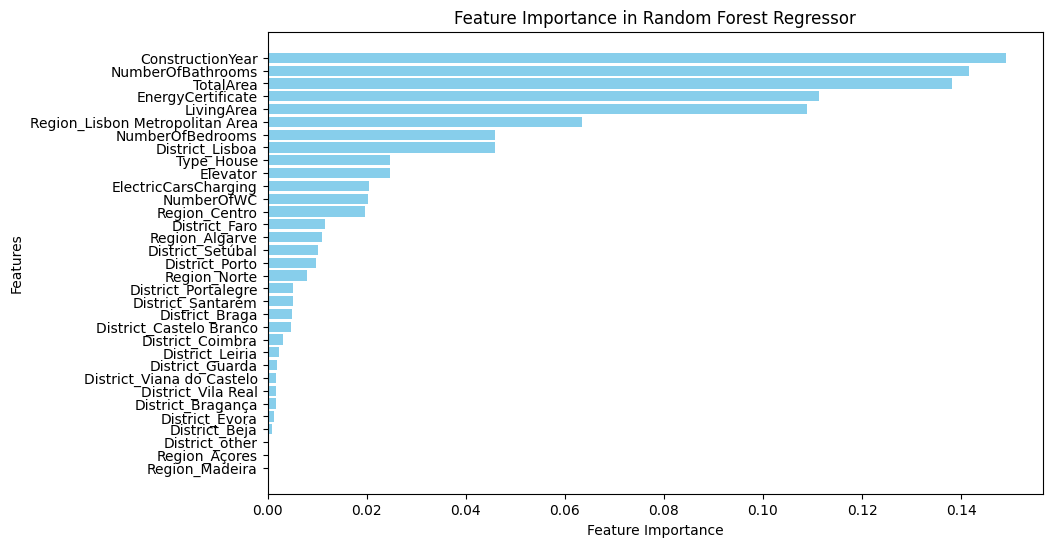

In [13]:
# Define parameter grid for random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize random forest regressor
rf = RandomForestRegressor(random_state=42)

# Perform grid search with 5-fold cross validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use best model for predictions
best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature importance plot
importances = best_model_rf.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

Mean Squared Error: 7343541290.301113
R^2 Score: 0.608208342360429


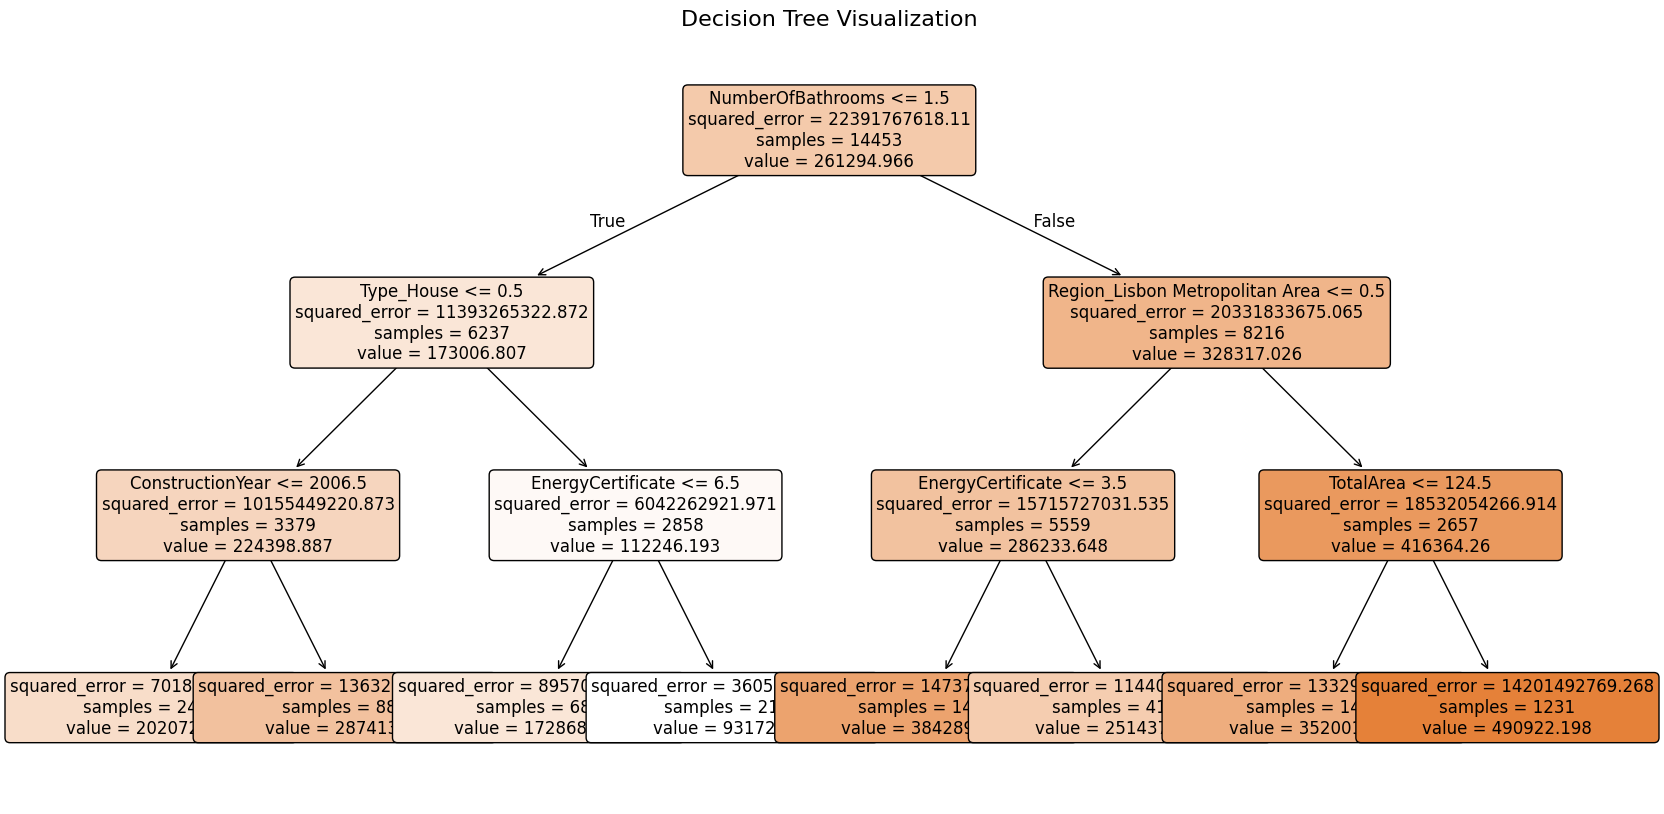

In [14]:
global_surrogates(best_model_rf, X_train, y_train)

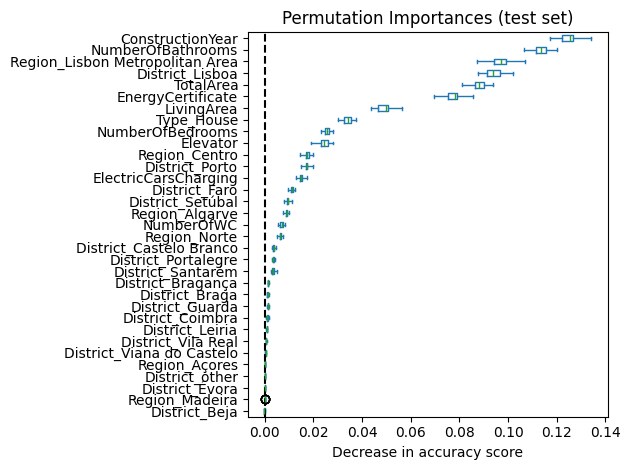

In [24]:
permutation_feature(best_model_rf, X_test, y_test)

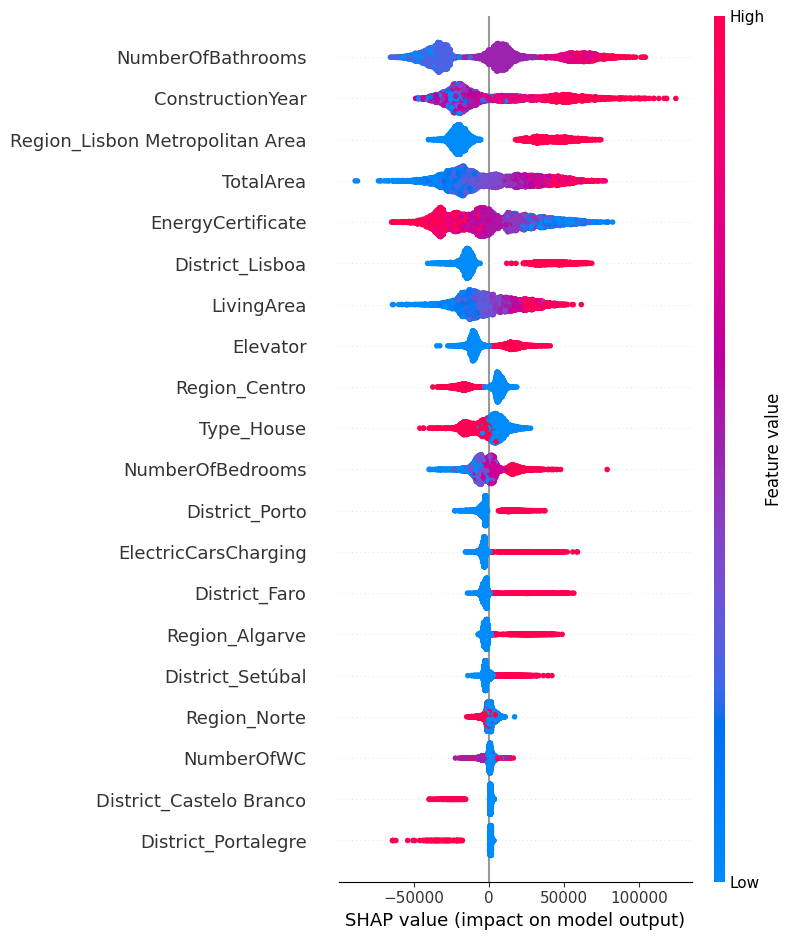

In [16]:
exec_shap(best_model_rf, X_test)

Example 1


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
3111,6,1980.0,107.0,0,0,4.0,2.0,107.0,3.0,1,170000.0


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
0,6,1998.0,107.0,0,0,4.0,2.0,107.0,3.0,1,186513.0
1,6,1937.0,107.0,0,0,4.0,2.0,107.0,3.0,1,139274.0
2,6,2005.0,107.0,0,0,4.0,5.0,107.0,3.0,1,235065.0
3,6,1990.0,107.0,0,0,4.0,2.0,107.0,3.0,1,190339.0


Example 2


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
15333,0,2014.0,153.0,1,0,4.0,0.0,153.0,2.0,0,750000.0


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
0,0,1925.0,153.0,0,0,4.0,0.0,153.0,2.0,0,390669.0
1,0,1971.0,153.0,1,0,4.0,0.0,153.0,2.0,0,391897.0
2,10,2014.0,153.0,1,0,5.0,0.0,153.0,2.0,0,414929.0
3,0,2014.0,153.0,1,0,4.0,0.0,269.1,2.0,1,488942.0


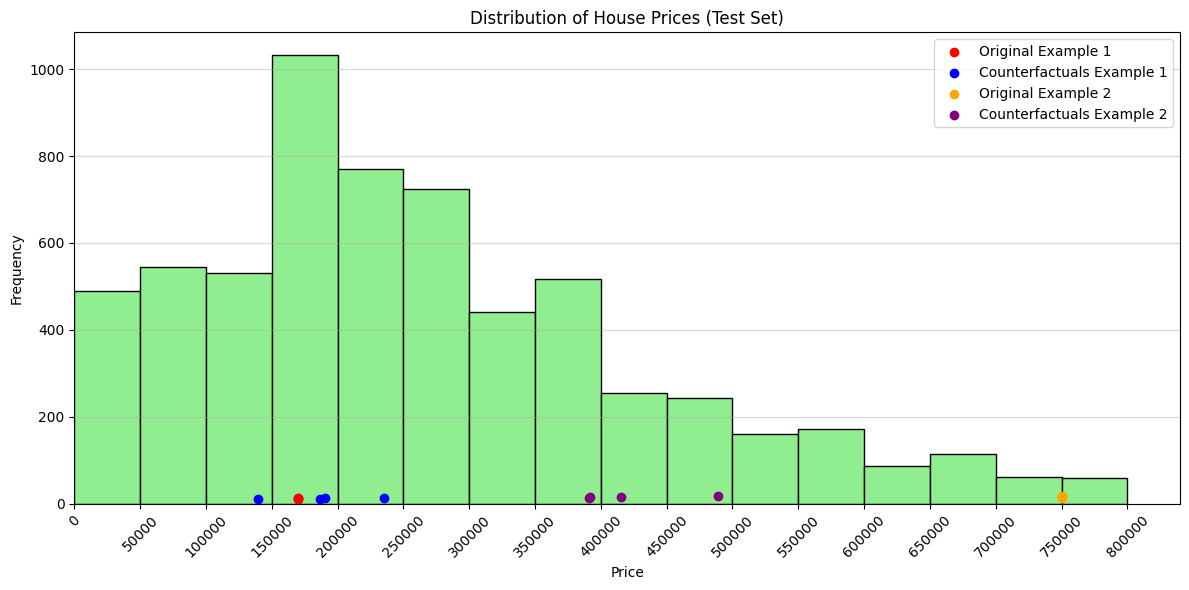

In [70]:
counterfactuals(best_model_rf, X_test, y_test)

<a id="nn"></a>
## **Black-box Model 2** : Neural Network Model
(Go back to [**Section 3**](#3-post-modeling-explanations))

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    Dense(1)
])

# Compile the model
nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = nn.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=150, batch_size=32, callbacks=[early_stopping])

# Predict and evaluate
y_pred = nn.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Epoch 1/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 97268883456.0000 - val_loss: 98130845696.0000
Epoch 2/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 96023052288.0000 - val_loss: 96919035904.0000
Epoch 3/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 94647558144.0000 - val_loss: 93539041280.0000
Epoch 4/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 90424942592.0000 - val_loss: 87459176448.0000
Epoch 5/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 84068450304.0000 - val_loss: 79323013120.0000
Epoch 6/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 75273805824.0000 - val_loss: 68588150784.0000
Epoch 7/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 64054947840.0000 - val_loss: 56710905856.0000
Epoch 8/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 54133678080.0000 - val_loss: 45342257152.0000
Epoch 9/150
452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 42708205568.0000 - val_loss: 35627220992.0000
Epoch 10/150
452/452 ━━━━━━━━━━━━━━━━

In [9]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 9147937672.09
R^2 Score: 0.68


452/452 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 16322601984.0000
646/646 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
Mean Squared Error: 919191602.1628227
R^2 Score: 0.7632198666173895


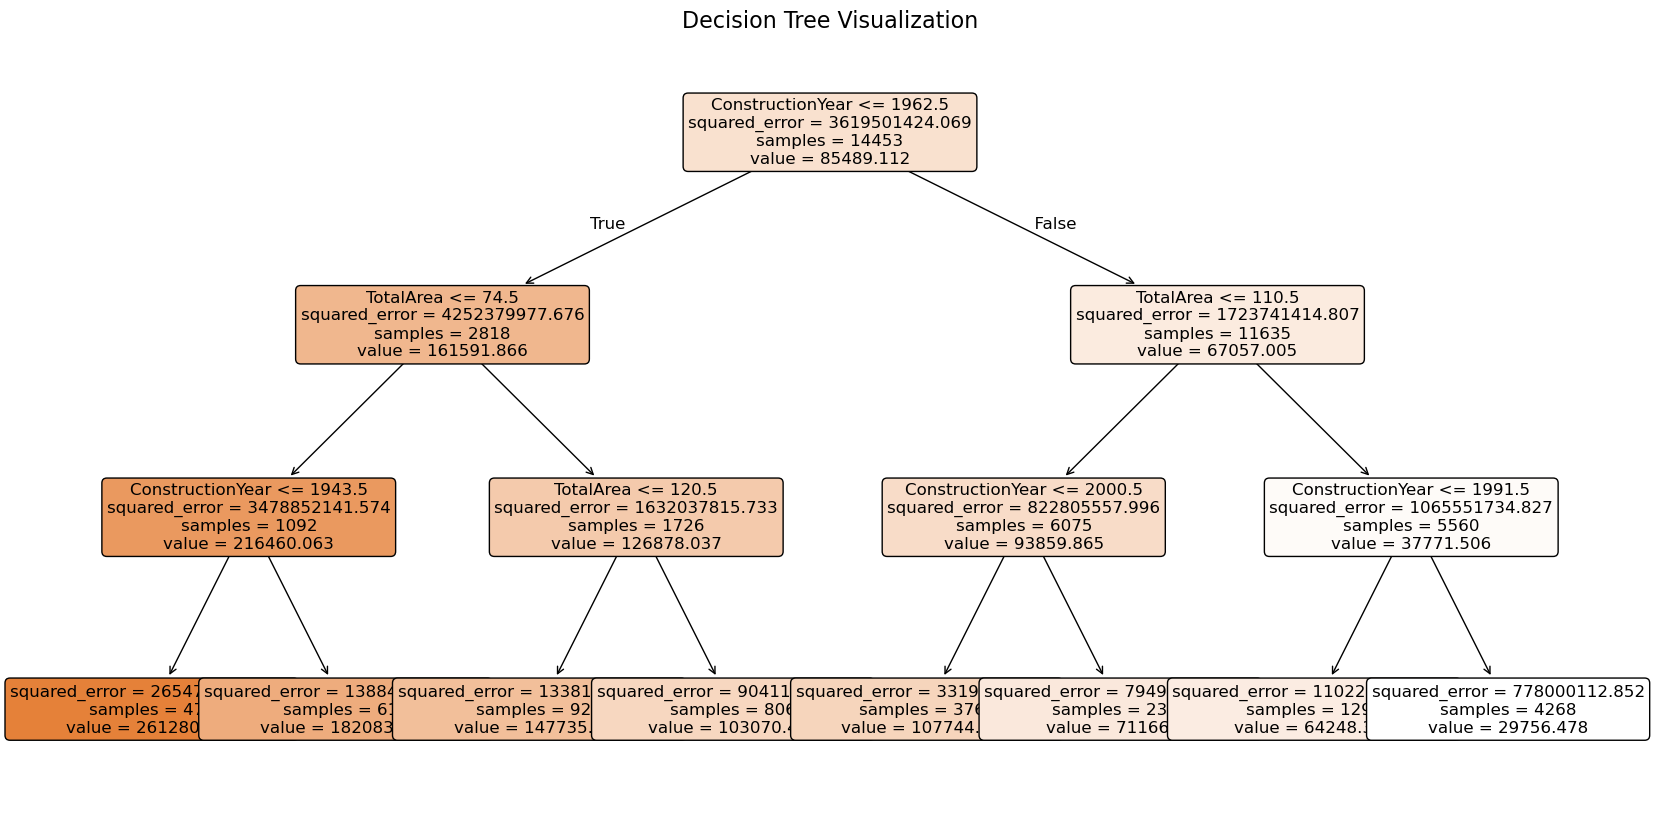

In [ ]:
global_surrogates(nn, X_train, y_train)

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
194/194 ━━━━━━━━

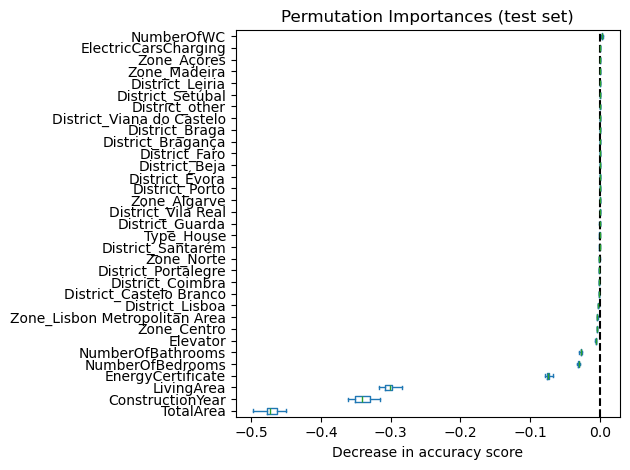

In [ ]:
permutation_feature(nn, X_test, y_test)

Example 1


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
3111,6,1980.0,107.0,0,0,4.0,2.0,107.0,3.0,1,170000.0


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
0,6,1980.0,107.0,0,0,8.0,2.0,107.0,3.0,1,104907080.0
1,6,1980.0,107.0,0,0,3.0,2.0,107.0,3.0,1,104971328.0
2,6,1980.0,224.1,1,0,4.0,2.0,107.0,3.0,1,110760632.0
3,6,1980.0,107.0,0,0,4.0,2.0,235.9,3.0,1,104724424.0


Example 2


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
15333,0,2014.0,153.0,1,0,4.0,0.0,153.0,2.0,0,750000.0


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


,EnergyCertificate,ConstructionYear,TotalArea,Elevator,ElectricCarsCharging,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,Type_House,Price
0,0,2014.0,271.7,1,0,4.0,0.0,153.0,2.0,1,114756344.0
1,0,2014.0,153.0,1,0,4.0,0.0,195.7,2.0,1,108874136.0
2,0,2014.0,153.0,1,0,4.0,4.0,153.0,2.0,0,108904144.0
3,0,2014.0,97.3,1,0,4.0,0.0,153.0,2.0,0,105976504.0


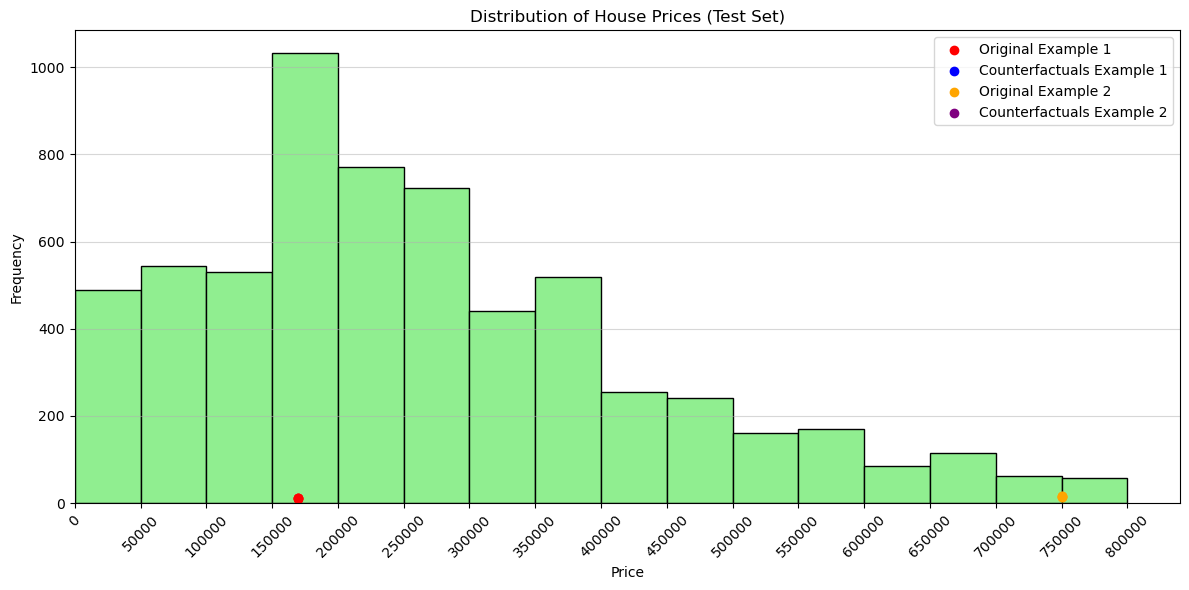

In [16]:
counterfactuals(nn, X_test, y_test)

## **4.** Quality of the explanations

The quality of the explanations will be addressed in the report